# 02_model_training.ipynb
## Entraînement & évaluation des modèles P7 (LogReg, DistilBERT)
# 1 - Imports & configuration

In [1]:
import os
import sys
import pandas as pd
import mlflow
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import joblib

In [2]:
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
from src.utils.load_models_from_p7 import load_logreg_model
from src.utils.text_utils import prepare_for_vectorization
from transformers import TextClassificationPipeline
from src.utils.vectorizer_utils import load_tfidf_vectorizer, vectorize_data, train_and_save_tfidf
from src.model_training import train_logreg_pipeline

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0516 09:03:22.719000 17464 venv_P9_V2\Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [4]:
# Bloc de vérification GPU
from src.utils.device_utils import check_gpu

In [5]:
device = check_gpu()

🔍 Vérification GPU (torch, tensorflow, nvidia-smi)...
❌ torch.cuda : Aucun GPU détecté
✅ TensorFlow : /physical_device:GPU:0 (CUDA 64_112, cuDNN 64_8)
✅ nvidia-smi : disponible
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |


# 2 - Chargement des données nettoyées

In [6]:
clean_path = '../data/processed/tweets_cleaned.csv'

df = pd.read_csv(clean_path)
df = df[['label', 'text']]
df.head()

,label,text
0,0,oh no where did u order from thats horrible
1,0,a great hard training weekend is over a couple...
2,0,right off to work only hours to go until im fr...
3,0,i am craving for japanese food
4,0,jean michel jarre concert tomorrow gotta work ...


# 3 - Préparation du jeu de test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size = 0.2, stratify = df['label'], random_state = 70)

# 4 - LogReg + TF-IDF : Prédiction & évaluation

In [8]:
model_dir = "../models/logreg_model"
logreg_model, acc_logreg, f1_logreg = train_logreg_pipeline(
    X_train, y_train,
    X_test, y_test,
    model_dir = model_dir,
    run_name = "logreg_imported",
    force_retrain = False,
    log_to_mlflow = True
)

# 5 - Matrice de confusion LogReg

In [9]:
vectorizer_path = os.path.join(model_dir, "tfidf_vectorizer.joblib")
tfidf_vectorizer = joblib.load(vectorizer_path)
X_test_vec = vectorize_data(tfidf_vectorizer, X_test)
y_pred_logreg = logreg_model.predict(X_test_vec)

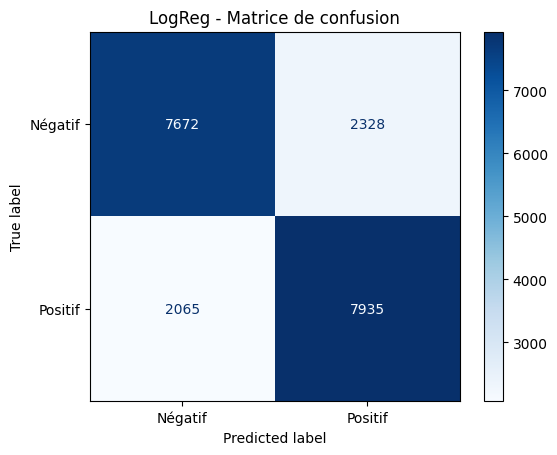

In [10]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix = cm_logreg, display_labels = ["Négatif", "Positif"])
disp_logreg.plot(cmap = 'Blues')
plt.title("LogReg - Matrice de confusion")
plt.show()

# 6 - Résultats récapitulatifs

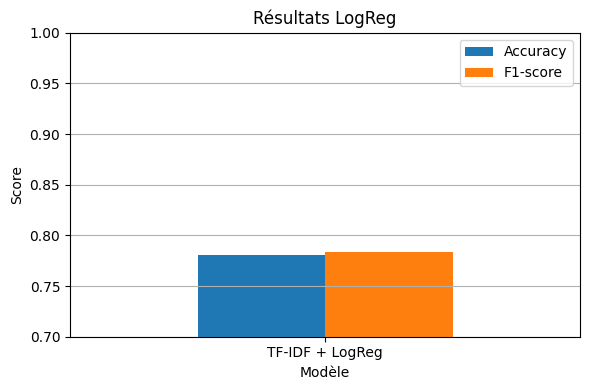

In [11]:
results_df = pd.DataFrame({
    "Modèle": ["TF-IDF + LogReg"],
    "Accuracy": [acc_logreg],
    "F1-score": [f1_logreg]
})

results_df.to_csv("../results/model_scores_logreg.csv", index=False)
results_df.plot(x="Modèle", kind="bar", rot=0, figsize=(6, 4))
plt.title("Résultats LogReg")
plt.ylim(0.7, 1)
plt.ylabel("Score")
plt.grid(axis='y')
plt.tight_layout()
plt.show()